In [2]:
# Imports

import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

from tensorflow.keras.layers import Layer
import tensorflow as tf

# Helper Functions

In [3]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer

class LinearRegressionModel(Layer):
  
  def __init__(self):
    super(LinearRegressionModel, self).__init__()

  def build(self, x):
    
    w_init = tf.random_normal_initializer()
    self.W = tf.Variable(
      initial_value=w_init(shape=(x[-1],1), dtype='float32'),
      trainable=True,
      name='weights'
    )
    
    b_init = tf.random_normal_initializer()
    self.b = tf.Variable(
      initial_value=b_init(shape=(1,), dtype='float32'),
      trainable=True,
      name='bias'
    )

  def call(self, x):
      return tf.matmul(x, self.W) + self.b

In [4]:
# test = LinearRegressionModel()
# test_x = np.ones((1,1))
# test_y = test(test_x) 
# test.variables

In [6]:
# Configuration Variables

number_of_observations = 12800
number_of_features = 1

EPOCHS = 100
bgd_batch = number_of_observations
sgd_batch = 1
mbgd_batch = 32

model_performance = {}

## Synthesizing the data

In [7]:
np.random.seed(0)

# Creating a observations
X_train = np.random.rand(number_of_observations,number_of_features)
X_valid = np.random.rand(number_of_observations,number_of_features)

# Instantiating the parameters W and b
W = np.round(np.random.rand(number_of_features,1)*10, 0)
b = np.round(np.random.rand(1,1),0)

# Creating some noise
noise = np.random.randn(number_of_observations,1)

# Creating y by doing XW + b and some noise
y_train = np.dot(X_train, W) + b + noise
y_valid = np.dot(X_valid, W) + b + noise

print(f"True W: {W[0][0]} \nTrue b: {b[0][0]}")

True W: 5.0 
True b: 1.0


## Visualize the Data

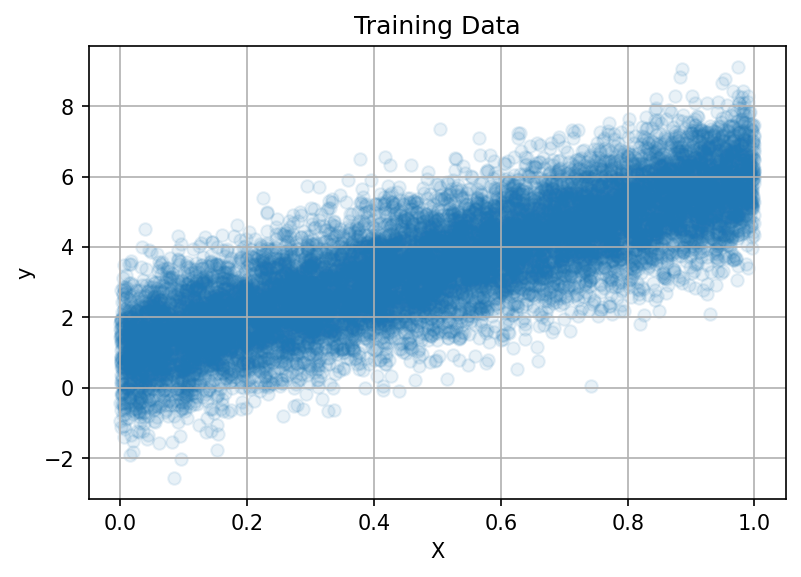

In [39]:
# Plotting the data

plt.scatter(X_train, y_train, alpha=0.1)
plt.title('Training Data')
plt.xlabel('X')
plt.ylabel('y')
plt.grid()

# Training the Model

## Tensorflow Sequential Model

In [9]:
def prepare_dataset(data, labels, batch, shuffle_buffer=100):
  '''
  Converts the numpy arrays into tensorflow dataset object with a batch size

  Parameters:
  -----------
  data (numpy array): the features of the data
  labels (numpy array): the target
  batch (int): the size of a batch
  shuffle_buffer (int): the buffer size for shuffling

  Returns:
  --------
  A shuffled Tensorflow dataset object
  '''

  dataset = tf.data.Dataset.from_tensor_slices((data, labels))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch).prefetch(1)
  return dataset

In [10]:
# Callbacks

# Creating a callback for early stopping
es_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Creating a callback for reducing learning rate
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='loss', 
  factor=0.2,
  patience=3, 
  min_lr=0.001
)

In [11]:
# Function that builds a general model

def build_model(train_set, validation_set):
  '''
  Builds and trains a Simple Linear Regression using a Tensorflow Sequential Model 

  Parameters:
  -----------
  None

  Returns:
  --------
  model: the built model
  history: object contains the training details
  '''
  
  tf.keras.backend.clear_session()

  model = tf.keras.Sequential([
    LinearRegressionModel()
  ])

  model.compile(
      loss=tf.keras.losses.mse,
      optimizer=tf.keras.optimizers.SGD(),
      metrics=['mse']
  )

  history = model.fit(
      train_set,
      epochs=EPOCHS,
      verbose=1,
      validation_data=validation_set,
      callbacks=[es_cb, reduce_lr_cb]
  )

  return model, history

## Batch Gradient Descent

In [12]:
batch_size = number_of_observations
train_dataset = prepare_dataset(X_train, y_train, batch_size)
valid_dataset = prepare_dataset(X_valid, y_valid, batch_size)

In [13]:
start_time = time.time()
bgd_model, bgd_history = build_model(train_dataset, valid_dataset)
bgd_elapsed_time = time.time() - start_time

Epoch 1/100
1/1 [==============================] - 1s 818ms/step - loss: 15.1506 - mse: 15.1506 - val_loss: 14.5416 - val_mse: 14.5416 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 72ms/step - loss: 14.4952 - mse: 14.4952 - val_loss: 13.9156 - val_mse: 13.9156 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - 0s 82ms/step - loss: 13.8724 - mse: 13.8724 - val_loss: 13.3206 - val_mse: 13.3206 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 74ms/step - loss: 13.2805 - mse: 13.2805 - val_loss: 12.7552 - val_mse: 12.7552 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 70ms/step - loss: 12.7179 - mse: 12.7179 - val_loss: 12.2177 - val_mse: 12.2177 - lr: 0.0100
Epoch 6/100
1/1 [==============================] - 0s 76ms/step - loss: 12.1833 - mse: 12.1833 - val_loss: 11.7069 - val_mse: 11.7069 - lr: 0.0100
Epoch 7/100
1/1 [==============================] - 0s 81ms/step - loss: 11.6753 - mse: 11.6753 - val_loss: 11.2215 - 

## Stochastic Gradient Descent

In [14]:
batch_size = 1
train_dataset = prepare_dataset(X_train, y_train, batch_size)
valid_dataset = prepare_dataset(X_valid, y_valid, batch_size)

In [15]:
start_time = time.time()
sgd_model, sgd_history = build_model(train_dataset, valid_dataset)
sgd_elapsed_time = time.time() - start_time

Epoch 1/100
12800/12800 [==============================] - 38s 3ms/step - loss: 1.0640 - mse: 1.0640 - val_loss: 1.0130 - val_mse: 1.0130 - lr: 0.0100
Epoch 2/100
12800/12800 [==============================] - 38s 3ms/step - loss: 1.0166 - mse: 1.0166 - val_loss: 1.0542 - val_mse: 1.0542 - lr: 0.0100
Epoch 3/100
12800/12800 [==============================] - 38s 3ms/step - loss: 1.0171 - mse: 1.0171 - val_loss: 1.0140 - val_mse: 1.0140 - lr: 0.0100
Epoch 4/100
12800/12800 [==============================] - 37s 3ms/step - loss: 1.0158 - mse: 1.0158 - val_loss: 1.0152 - val_mse: 1.0152 - lr: 0.0100
Epoch 5/100
12800/12800 [==============================] - 37s 3ms/step - loss: 1.0173 - mse: 1.0173 - val_loss: 1.0138 - val_mse: 1.0138 - lr: 0.0100
Epoch 6/100
12800/12800 [==============================] - 29s 2ms/step - loss: 1.0165 - mse: 1.0165 - val_loss: 1.0319 - val_mse: 1.0319 - lr: 0.0100
Epoch 7/100
12800/12800 [==============================] - 37s 3ms/step - loss: 1.0163 - mse: 

## Mini-Batch Gradient Descent

In [16]:
batch_size = 64
train_dataset = prepare_dataset(X_train, y_train, batch_size)
valid_dataset = prepare_dataset(X_valid, y_valid, batch_size)

In [17]:
start_time = time.time()
mbgd_model, mbgd_history = build_model(train_dataset, valid_dataset)
mbgd_elapsed_time = time.time() - start_time

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 3.1206 - mse: 3.1206 - val_loss: 1.5845 - val_mse: 1.5845 - lr: 0.0100
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 1.4832 - mse: 1.4832 - val_loss: 1.3358 - val_mse: 1.3358 - lr: 0.0100
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 1.2850 - mse: 1.2850 - val_loss: 1.1921 - val_mse: 1.1921 - lr: 0.0100
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 1.1685 - mse: 1.1685 - val_loss: 1.1092 - val_mse: 1.1092 - lr: 0.0100
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 1.1000 - mse: 1.1000 - val_loss: 1.0616 - val_mse: 1.0616 - lr: 0.0100
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 1.0599 - mse: 1.0599 - val_loss: 1.0345 - val_mse: 1.0345 - lr: 0.0100
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 1.0363 - mse: 1.0363 - val_loss: 1.0193 - val_mse

In [18]:
# Predicting 

bgd_preds = bgd_model.predict(X_valid)
sgd_preds = sgd_model.predict(X_valid)
mbgd_preds = mbgd_model.predict(X_valid)

400/400 [==============================] - 0s 1ms/step


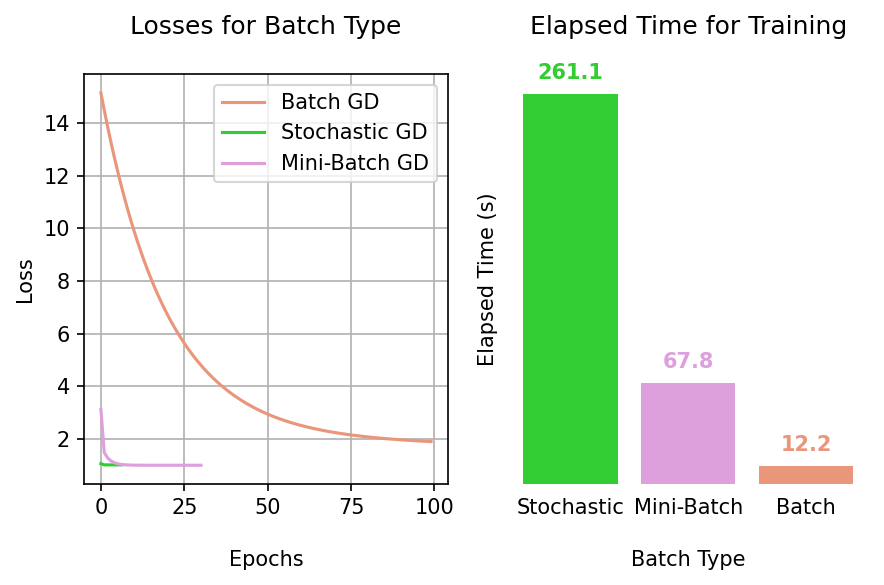

In [35]:
# Plotting the data

colors = ['limegreen', 'plum', 'darksalmon' ]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(bgd_history.history['loss'], color='darksalmon', label='Batch GD')
ax1.plot(sgd_history.history['loss'], color='limegreen', label='Stochastic GD')
ax1.plot(mbgd_history.history['loss'], color='plum', label='Mini-Batch GD')
ax1.set_title("Losses for Batch Type\n")
ax1.set_xlabel('\nEpochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

def add_labels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+10, np.round(y[i],1), ha = 'center', color=colors[i], weight='bold')

ax2.bar(x=['Stochastic', 'Mini-Batch', 'Batch'], height=[sgd_elapsed_time, mbgd_elapsed_time, bgd_elapsed_time], color=colors)
ax2.set_title("Elapsed Time for Training\n")
ax2.set_xlabel("\nBatch Type")
ax2.set_ylabel("Elapsed Time (s)")
add_labels(['Stochastic', 'Mini-Batch', 'Batch'], [sgd_elapsed_time, mbgd_elapsed_time, bgd_elapsed_time])

# Removing the borders
for spine in plt.gca().spines.values():
  spine.set_visible(False)

# Removing unnecessary ticks
ax2.tick_params(left=False)
ax2.tick_params(bottom=False)
ax2.set_yticks([])

plt.tight_layout()

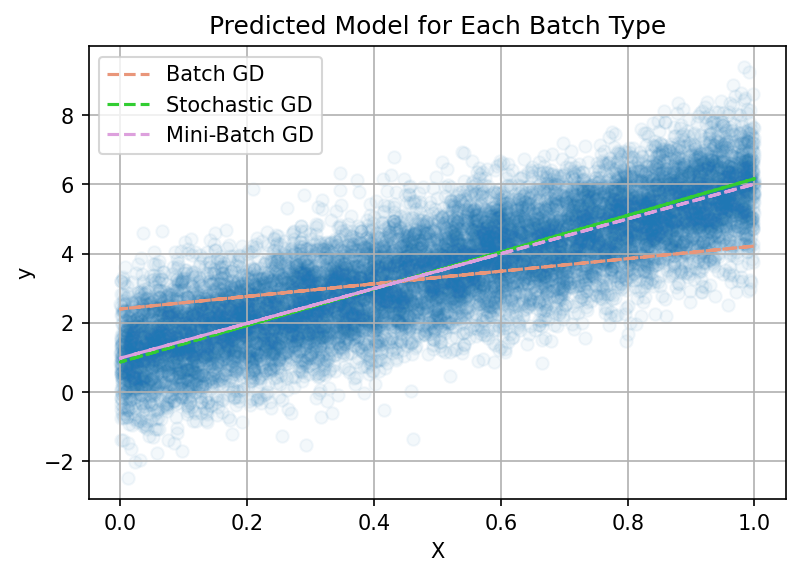

In [38]:
# Plotting Elapsed Time

fig, ax1 = plt.subplots(1,1)

ax1.scatter(X_valid, y_valid, alpha=0.05)
ax1.plot(X_valid, bgd_preds, color='darksalmon', label='Batch GD', linestyle='--')
ax1.plot(X_valid, sgd_preds, color='limegreen', label='Stochastic GD', linestyle='--')
ax1.plot(X_valid, mbgd_preds, color='plum', label='Mini-Batch GD', linestyle='--')
ax1.set_title('Predicted Model for Each Batch Type')
ax1.set_xlabel('X')
ax1.set_ylabel('y')
ax1.legend()
ax1.grid()